In [1]:
%load_ext autoreload
%autoreload 2

from math import pi
from glob import glob

import numpy as np
import matplotlib.pyplot as plt

from root_pandas import read_root

Welcome to JupyROOT 6.10/04


In [2]:
import ROOT

In [3]:
detector_x = [0, 256.35]
detector_x = [-50, 315]
detector_y = [-116.5, 116.5]
detector_z = [0, 1036.8]

In [4]:
plt.rcParams.update({'font.size': 18})

## Useful functions

In [5]:
def point_is_fiducial(x, y, z, fiducial_x=[10, -10], fiducial_y=[20, -20], fiducial_z=[20, -20]):
#     is_x = (detector_x[0] + fiducial_x[0] < df[x]) & (df[x] < detector_x[1] + fiducial_x[1])
    is_y = (detector_y[0] + fiducial_y[0] < df[y]) & (df[y] < detector_y[1] + fiducial_y[1])
    is_z = (detector_z[0] + fiducial_z[0] < df[z]) & (df[z] < detector_z[1] + fiducial_z[1])
    return is_y & is_z

def PitchY(xs,ys,zs,xe,ye,ze):
    sdir = np.array([df[xs],df[ys],df[zs]])
    edir = np.array([df[xe],df[ye],df[ze]])
    tdir = edir-sdir
    tmag = np.sqrt(tdir[0]**2+tdir[1]**2+tdir[2]**2)
    theta = np.arccos(tdir[2]/tmag)
    #theta = np.arccos(tdir.Z())
    return theta

def MediandQdx(x):
    return np.median(x['_dqdx_v'])

## Load datasets

In [6]:
file_dir = "/home/david/data/StopMuCalibration/"
file_list = glob(file_dir+"/throughmu.root")
print file_list

['/home/david/data/StopMuCalibration//throughmu.root']


In [7]:
df = read_root(file_list, key="throughmu/_trk_tree")
print df.shape

(602490, 10)


Warning in <TClass::Init>: no dictionary for class ROOT::TIOFeatures is available


In [8]:
df['start_is_fiducial'] = point_is_fiducial('_trk_start_x', '_trk_start_y', '_trk_start_z')
df['end_is_fiducial'] = point_is_fiducial('_trk_end_x', '_trk_end_y', '_trk_end_z')

In [9]:
df['start_x_fiducial'] = (detector_x[0] + 10 < df['_trk_start_x']) & (df['_trk_start_x'] < detector_x[1] -10)
df['end_x_fiducial'] = (detector_x[0] + 10 < df['_trk_end_x']) & (df['_trk_end_x'] < detector_x[1] -10)

In [10]:
df['theta'] = PitchY('_trk_start_x','_trk_start_y','_trk_start_z','_trk_end_x','_trk_end_y','_trk_end_z')

In [11]:
df['pitch'] = 0.3/np.cos(df['theta'])#df.apply(lambda x : 0.3/np.cos(df['theta']),axis=1)

In [12]:
#df['median_dqdx'] = df.apply(lambda x: MediandQdx(x), axis=1)

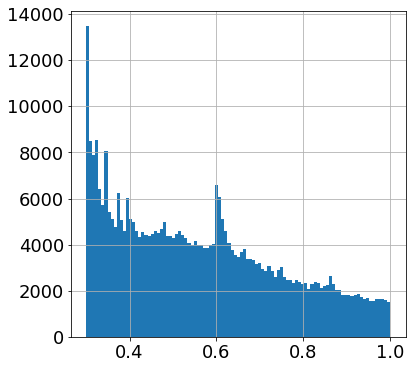

In [13]:
fig = plt.figure(figsize=(6,6))
plt.hist(np.abs(df['pitch'].values),bins=np.linspace(0.3,1,100))
plt.grid()
plt.show()

calculated density is 1.381 [g/cm^3]
R @ 2.1 MeV/cm : 0.3671


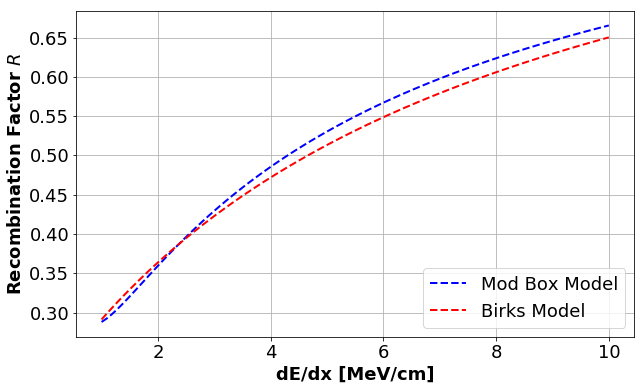

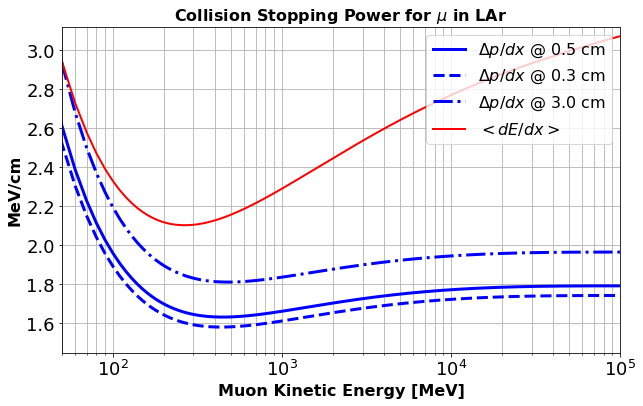

In [14]:
from Recombination import RecombModBox
from LandauEloss import dedx, dpdx

In [15]:
selected2_df = df.query('start_is_fiducial==False & end_is_fiducial==False & _trk_len>50 and _pl==2')
selected1_df = df.query('start_is_fiducial==False & end_is_fiducial==False & _trk_len>50 and _pl==1')
selected0_df = df.query('start_is_fiducial==False & end_is_fiducial==False & _trk_len>50 and _pl==0')

In [16]:
dqdx_v_2 = np.hstack(selected2_df['_dqdx_v'].values)
dqdx_v_1 = np.hstack(selected1_df['_dqdx_v'].values)
dqdx_v_0 = np.hstack(selected0_df['_dqdx_v'].values)

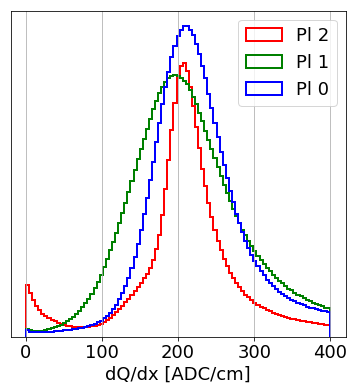

In [17]:
fig = plt.figure(figsize=(6,6))
BINS = np.linspace(0,400,100)
plt.hist(dqdx_v_2,bins=BINS,color='r',lw=2,histtype='step',label='Pl 2')
plt.hist(dqdx_v_1,bins=BINS,color='g',lw=2,histtype='step',label='Pl 1')
plt.hist(dqdx_v_0,bins=BINS,color='b',lw=2,histtype='step',label='Pl 0')
plt.grid()
plt.xlabel('dQ/dx [ADC/cm]')
plt.gca().get_yaxis().set_visible(False)
plt.legend()
plt.show()

In [18]:
# assume uniform distribution from 1 to 10 GeV
# sample from pitch distribution of sample

dpdx_v_th = []
dqdx_v_th = []

for i in xrange(60000):
    mu_energy = np.random.rand()*9 + 1
    pitch = np.abs(df['pitch'][i])
    dpdxval = dpdx(mu_energy*1e3,pitch,105.)
    R = RecombModBox(dpdxval)
    dqdx = dpdxval * (1-R) / (23.6/1e3)
    dpdx_v_th.append(dpdxval)
    dqdx_v_th.append(dqdx)

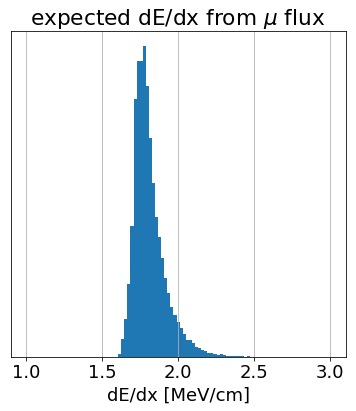

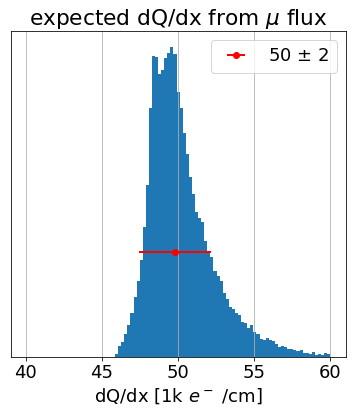

In [72]:
fig = plt.figure(figsize=(6,6))
plt.hist(dpdx_v_th,bins=np.linspace(1,3,100))
plt.grid()
plt.title('expected dE/dx from $\mu$ flux')
plt.xlabel('dE/dx [MeV/cm]')
plt.gca().get_yaxis().set_visible(False)
plt.show()

fig = plt.figure(figsize=(6,6))
plt.hist(dqdx_v_th,bins=np.linspace(4e1,6e1,100))
med = np.median(dqdx_v_th)
std = np.std(dqdx_v_th)
plt.errorbar(med,1000.,xerr=std,fmt='o',color='r',lw=2,label='%.0f $\pm$ %.0f'%(med,std))
plt.grid()
plt.legend()
plt.title('expected dQ/dx from $\mu$ flux')
plt.xlabel('dQ/dx [1k $e^-$ /cm]')
plt.gca().get_yaxis().set_visible(False)
plt.show()

In [21]:
# pylandau from https://github.com/SiLab-Bonn/pylandau
from pylandau import langau

In [27]:
from scipy.optimize import curve_fit

In [48]:
# PLANE 2
vals2,bine2 = np.histogram(dqdx_v_2,bins=np.linspace(100,400,100))
valsmax2 = np.max(vals2)
vals2 = vals2.astype(float)
vals2 /= valsmax2
binc2 = 0.5*(bine2[1:]+bine2[:-1])
# PLANE 1
vals1,bine1 = np.histogram(dqdx_v_1,bins=np.linspace(100,400,100))
valsmax1 = np.max(vals1)
vals1 = vals1.astype(float)
vals1 /= valsmax1
binc1 = 0.5*(bine1[1:]+bine1[:-1])
# PLANE 0
vals0,bine0 = np.histogram(dqdx_v_0,bins=np.linspace(100,400,100))
valsmax0 = np.max(vals0)
vals0 = vals0.astype(float)
vals0 /= valsmax0
binc0 = 0.5*(bine0[1:]+bine0[:-1])

In [49]:
guess2 = [200,20,20]
guess1 = [200,40,40]
guess0 = [200,40,40]
popt2,popv2 = curve_fit(langau,binc2,vals2,p0=guess2)
popt1,popv1 = curve_fit(langau,binc1,vals1,p0=guess1)
popt0,popv0 = curve_fit(langau,binc0,vals0,p0=guess0)

In [50]:
print popt2
print popt1
print popt0

[206.83010152   9.15617238  18.81341595]
[193.2301053   20.4095827   42.10434315]
[209.4379909   13.29485462  32.87988601]


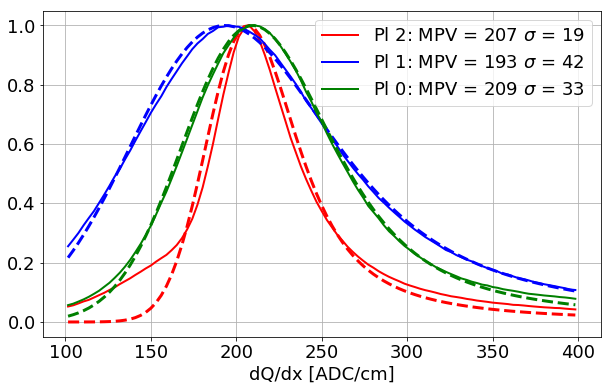

In [61]:
fig = plt.figure(figsize=(10,6))
plt.plot(binc2,vals2,'r-',lw=2,label='Pl 2: MPV = %.0f $\sigma$ = %.0f'%(popt2[0],popt2[2]))
plt.plot(binc2,langau(binc,*popt2),'r--',lw=3)
plt.plot(binc1,vals1,'b-',lw=2,label='Pl 1: MPV = %.0f $\sigma$ = %.0f'%(popt1[0],popt1[2]))
plt.plot(binc1,langau(binc,*popt1),'b--',lw=3)
plt.plot(binc0,vals0,'g-',lw=2,label='Pl 0: MPV = %.0f $\sigma$ = %.0f'%(popt0[0],popt0[2]))
plt.plot(binc0,langau(binc,*popt0),'g--',lw=3)
plt.grid()
plt.xlabel('dQ/dx [ADC/cm]')
plt.legend(loc=1)
plt.show()

In [73]:
# Gain obtained by tuning MPV to theoretical expectation of 50 +/- 2
G2  = 5e4 / popt2[0]
G2e = 2e3 / popt2[0]
G1  = 5e4 / popt1[0]
G1e = 2e3 / popt1[0]
G0  = 5e4 / popt0[0]
G0e = 2e3 / popt0[0]

In [77]:
print 'Gain Pl2 : %.01f +/- %.01f'%(G2,G2e)
print 'Gain Pl1 : %.01f +/- %.01f'%(G1,G1e)
print 'Gain Pl0 : %.01f +/- %.01f'%(G0,G0e)

Gain Pl2 : 241.7 +/- 9.7
Gain Pl1 : 258.8 +/- 10.4
Gain Pl0 : 238.7 +/- 9.5
